In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use("seaborn-v0_8")
PHASE1_FIG_DIR = "outputs/figures/phase1"
os.makedirs(PHASE1_FIG_DIR, exist_ok=True)

In [2]:
BASE_DATA_DIR = "../data/raw"

G1020_PATH = os.path.join(BASE_DATA_DIR, "g1020")
REFUGE_PATH = os.path.join(BASE_DATA_DIR, "refuge")

assert os.path.exists(G1020_PATH), "G1020 path not found"
assert os.path.exists(REFUGE_PATH), "REFUGE path not found"

G1020 Loader

In [3]:
def load_g1020_dataset(base_path):
    records = []

    for split in ["training", "testing"]:
        for label in ["glaucoma", "normal"]:
            folder = os.path.join(base_path, split, label)
            for img_name in os.listdir(folder):
                if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                    records.append({
                        "dataset": "G1020",
                        "split": split,
                        "label": label,
                        "image_path": os.path.join(folder, img_name)
                    })
    return pd.DataFrame(records)

REFUGE Loader

In [4]:
def load_refuge_dataset(base_path):
    records = []

    for split in ["training", "val", "testing"]:
        img_dir = os.path.join(base_path, split, "images")
        mask_dir = os.path.join(base_path, split, "mask")

        for img_name in os.listdir(img_dir):
            if img_name.lower().endswith((".jpg", ".png")):
                records.append({
                    "dataset": "REFUGE",
                    "split": split,
                    "label": "unknown",  # labels inferred later
                    "image_path": os.path.join(img_dir, img_name),
                    "mask_path": os.path.join(mask_dir, img_name)
                })
    return pd.DataFrame(records)

In [5]:
g1020_df = load_g1020_dataset(G1020_PATH)
refuge_df = load_refuge_dataset(REFUGE_PATH)

print("G1020 samples:", len(g1020_df))
print("REFUGE samples:", len(refuge_df))

G1020 samples: 1020
REFUGE samples: 1200


In [6]:
os.makedirs("outputs/metrics", exist_ok=True)
g1020_df.to_csv("outputs/metrics/g1020_metadata.csv", index=False)
refuge_df.to_csv("outputs/metrics/refuge_metadata.csv", index=False)

EDA

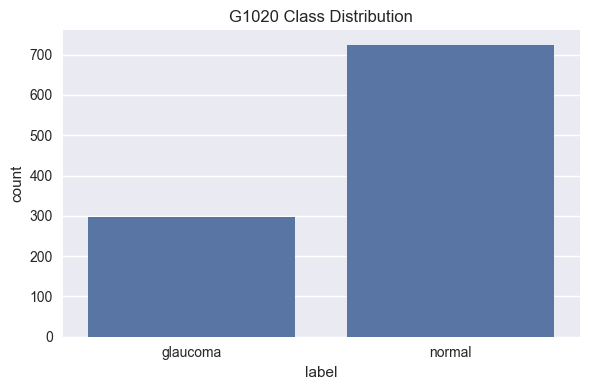

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=g1020_df, x="label")
plt.title("G1020 Class Distribution")
plt.tight_layout()
plt.savefig("outputs/figures/phase1/g1020_class_distribution.png")
plt.show()

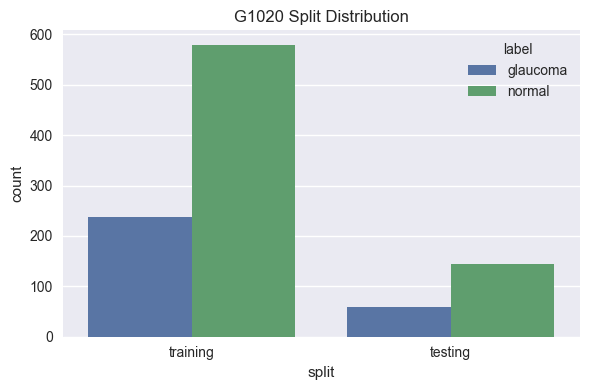

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=g1020_df, x="split", hue="label")
plt.title("G1020 Split Distribution")
plt.tight_layout()
plt.savefig("outputs/figures/phase1/g1020_split_distribution.png")
plt.show()

In [9]:
def analyze_image_sizes(df, sample_size=500):
    widths, heights = [], []

    for path in tqdm(df["image_path"].sample(min(sample_size, len(df)))):
        img = cv2.imread(path)
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)

    return widths, heights

In [10]:
g_w, g_h = analyze_image_sizes(g1020_df)
r_w, r_h = analyze_image_sizes(refuge_df)

100%|██████████| 500/500 [00:14<00:00, 34.07it/s]


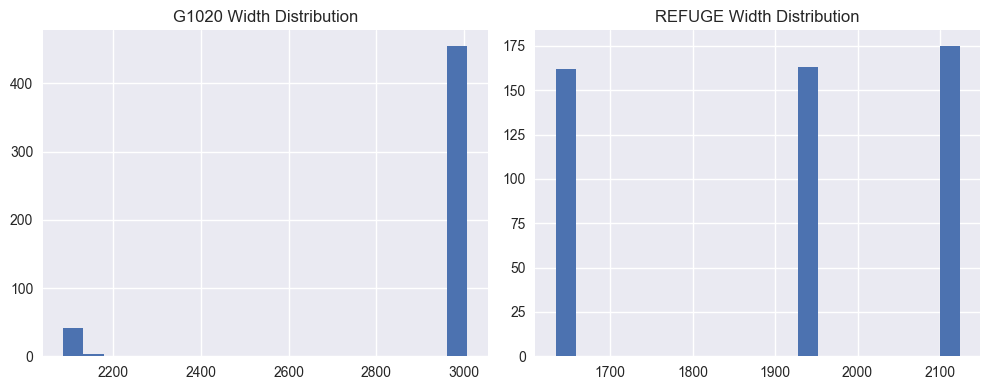

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(g_w, bins=20)
plt.title("G1020 Width Distribution")

plt.subplot(1,2,2)
plt.hist(r_w, bins=20)
plt.title("REFUGE Width Distribution")

plt.tight_layout()
plt.savefig("outputs/figures/phase1/image_resolution_distribution.png")
plt.show()

In [12]:
def show_samples(df, title, n=5):
    samples = df.sample(n)
    plt.figure(figsize=(15,3))

    for i, (_, row) in enumerate(samples.iterrows()):
        img = cv2.imread(row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(row.get("label", ""))

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

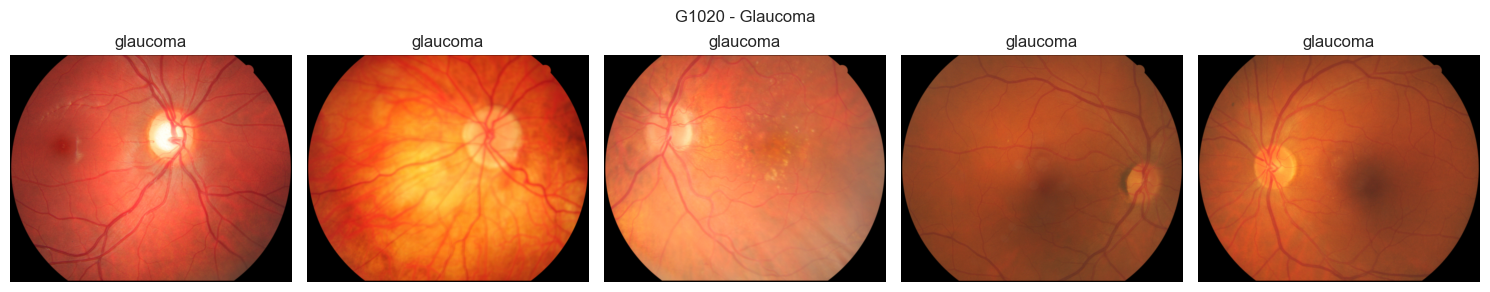

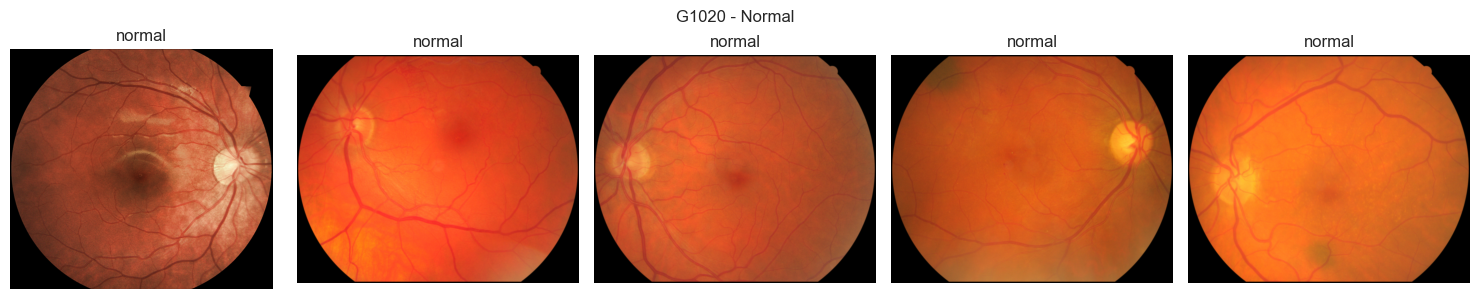

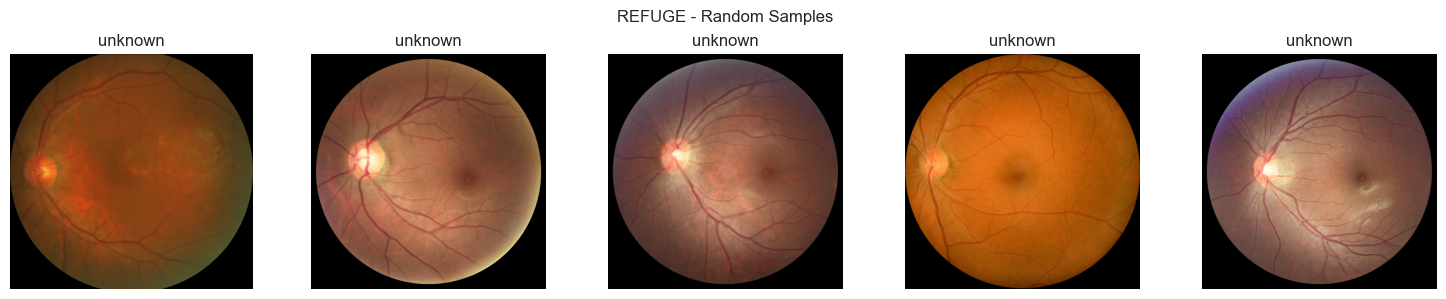

In [13]:
show_samples(g1020_df[g1020_df.label=="glaucoma"], "G1020 - Glaucoma")
show_samples(g1020_df[g1020_df.label=="normal"], "G1020 - Normal")
show_samples(refuge_df, "REFUGE - Random Samples")

In [14]:
def plot_color_histogram(df, title, sample_size=100, resize=(128, 128)):
    """
    Memory-safe color distribution analysis.
    """
    r_vals, g_vals, b_vals = [], [], []

    sampled_paths = df["image_path"].sample(
        min(sample_size, len(df)), random_state=42
    )

    for path in tqdm(sampled_paths):
        img = cv2.imread(path)

        if img is None:
            continue

        # Resize to reduce memory usage
        img = cv2.resize(img, resize)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        r_vals.append(img[:, :, 0].ravel())
        g_vals.append(img[:, :, 1].ravel())
        b_vals.append(img[:, :, 2].ravel())

        del img  # explicit memory release

    r_vals = np.concatenate(r_vals)
    g_vals = np.concatenate(g_vals)
    b_vals = np.concatenate(b_vals)

    plt.figure(figsize=(8, 4))
    plt.hist(r_vals, bins=50, alpha=0.5, label="Red", density=True)
    plt.hist(g_vals, bins=50, alpha=0.5, label="Green", density=True)
    plt.hist(b_vals, bins=50, alpha=0.5, label="Blue", density=True)
    plt.legend()
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.tight_layout()

    plt.savefig(os.path.join(PHASE1_FIG_DIR, f"{title.lower().replace(' ', '_')}.png"))
    plt.show()

100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


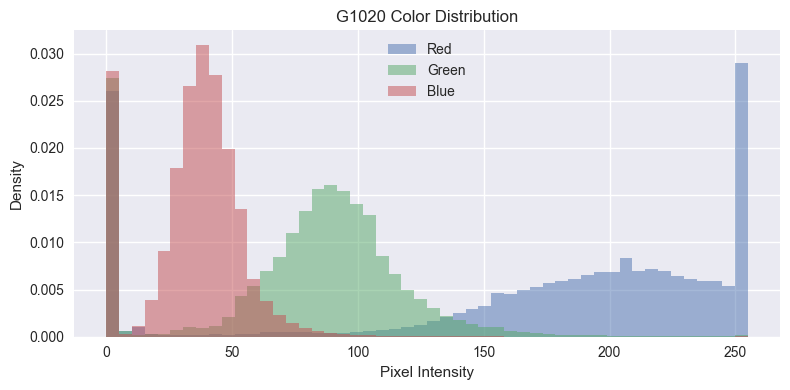

100%|██████████| 100/100 [00:02<00:00, 36.07it/s]


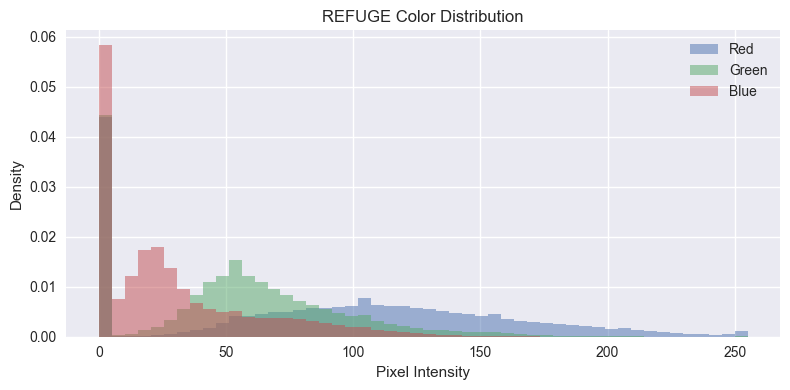

In [15]:
plot_color_histogram(g1020_df, "G1020 Color Distribution")
plot_color_histogram(refuge_df, "REFUGE Color Distribution")